# **REKOM Methodology and Evaluation**

By:

**Chariz Dianne Falco**

**Mauricio Manuel Bergancia**

**Mark Andrei Encanto**

**Mherlie Joy Chavez**

**Rhazel Jay Gumacal**

In [ ]:
# importing libraries 
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

In [2]:
# Load Data
def load_data():
    movies = pd.read_csv('dataset/movies.dat', sep='::', engine='python',
                         names=['MovieID', 'Title', 'Genres'], encoding='latin-1')
    ratings = pd.read_csv('dataset/ratings.dat', sep='::', engine='python',
                          names=['UserID', 'MovieID', 'Rating', 'Timestamp'], encoding='latin-1')
    users = pd.read_csv('dataset/users.dat', sep='::', engine='python',
                        names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], encoding='latin-1')
    return movies, ratings, users

movies, ratings, users = load_data()

### **Create TF-IDF and SVD Models**

For our Movie Recommendation System to work, we will use the following: 

>**TF-IDF with Content-Based Filtering** - this leverages movie metadata (Genres) to recommend similar items based on content alone—independent of user ratings. We considered this approach because:
    > 1. Our dataset includes rich content features (like Genres).
    > 2. It works for new users with few or no ratings (solves the cold-start problem).
    > 3. It’s interpretable—recommendations are based on movie similarity.

> **SVD (Singular Value Decomposition)** - a powerful matrix factorization technique that learns latent features from user-item rating patterns to make personalized recommendations.
    > 1. Your dataset includes a large matrix of user ratings (MovieLens).
    > 2. SVD can capture hidden user preferences and movie traits beyond surface content.
    > 3. It provides strong numerical prediction performance (e.g., RMSE).

In [3]:
# TF-IDF Content-based Filtering
# Improved vectorizer
tfidf = TfidfVectorizer(token_pattern=r'[^|]+', ngram_range=(1, 2), stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['Genres'].str.replace('|', ' '))
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
movie_indices = pd.Series(movies.index, index=movies['MovieID'])

# Predict TF-IDF scores for a user
def predict_tfidf_ratings(user_id):
    user_rated = ratings[ratings['UserID'] == user_id]
    rated_movie_ids = user_rated['MovieID'].tolist()
    user_genres = movies[movies['MovieID'].isin(rated_movie_ids)]['Genres']
    genre_text = " ".join(user_genres).replace('|', ' ')

    user_vec = tfidf.transform([genre_text])
    sim_scores = linear_kernel(user_vec, tfidf_matrix).flatten()

    tfidf_preds = []
    for mid in movies['MovieID']:
        idx = movie_indices.get(mid)
        if idx is not None:
            tfidf_preds.append((user_id, mid, sim_scores[idx]))

    return tfidf_preds

In [4]:
# Collaborative Filtering using SVD
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['UserID', 'MovieID', 'Rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
svd = SVD()
svd.fit(trainset)

In [5]:
# Predict and Evaluate RMSE for SVD
predictions_svd = svd.test(testset)
rmse_svd = accuracy.rmse(predictions_svd)
print(f"SVD - RMSE: {rmse_svd:.4f}")


RMSE: 0.8742
SVD - RMSE: 0.8742


In [ ]:
# Prepare TF-IDF test set to match testset format
def get_true_ratings(user_id):
    return ratings[ratings['UserID'] == user_id][['MovieID', 'Rating']].set_index('MovieID')['Rating'].to_dict()

In [7]:
# Predict and Evaluate RMSE for TF-IDF manually
true_ratings = []
pred_ratings = []

for uid, mid, true_r in testset:
    tfidf_preds = predict_tfidf_ratings(uid)
    pred_dict = {m: r for _, m, r in tfidf_preds}
    if mid in pred_dict:
        true_ratings.append(true_r)
        pred_ratings.append(pred_dict[mid])

if pred_ratings:
    rmse_tfidf = np.sqrt(np.mean((np.array(true_ratings) - np.array(pred_ratings)) ** 2))
    print(f"TF-IDF - RMSE: {rmse_tfidf:.4f}")
else:
    print("TF-IDF - No valid predictions to compute RMSE.")

TF-IDF - RMSE: 3.7518



📊 RMSE Summary Table:
 Model     RMSE
   SVD 0.874223
TF-IDF 3.751841


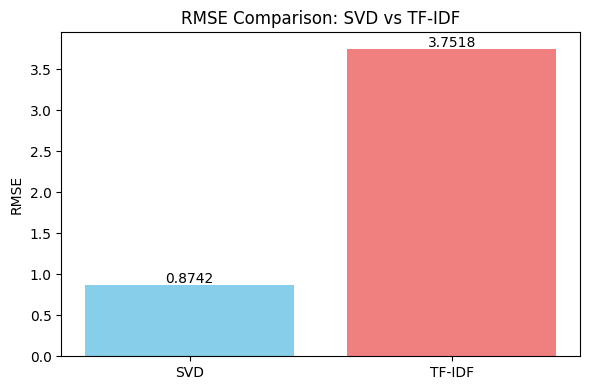

In [8]:
import matplotlib.pyplot as plt

# Summary table
summary = pd.DataFrame({
    'Model': ['SVD', 'TF-IDF'],
    'RMSE': [rmse_svd, rmse_tfidf if pred_ratings else np.nan]
})

print("\n📊 RMSE Summary Table:")
print(summary.to_string(index=False))

# Visualization
plt.figure(figsize=(6, 4))
bars = plt.bar(summary['Model'], summary['RMSE'], color=['skyblue', 'lightcoral'])
plt.title('RMSE Comparison: SVD vs TF-IDF')
plt.ylabel('RMSE')
plt.ylim(0, max(summary['RMSE'].dropna()) + 0.2)

# Annotate bars with values
for bar in bars:
    yval = bar.get_height()
    if not np.isnan(yval):
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f'{yval:.4f}', ha='center')

plt.tight_layout()
plt.show()


In the graph, we can clearly say that:

**1. SVD Strongly Outperforms TF-IDF**
The SVD model has an RMSE of 0.8742, which is very low — indicating that it predicts user ratings with high accuracy. The TF-IDF model has a much higher RMSE of 3.7518, signaling poor accuracy in predicting how users would rate movies.

**2. Scale of Difference**
The RMSE of TF-IDF is more than 4× higher than SVD, visually emphasized by the height of the red bar. This large gap shows that SVD is substantially superior in capturing user preferences.

**3. Model Suitability**
The graph suggests that if rating prediction accuracy is critical, SVD is the clear choice. TF-IDF might still be useful in cold-start scenarios, but its predictions should not be relied on for rating estimation.

**4. Model Complexity vs. Performance**
Though SVD is more computationally complex, the return on investment is high in terms of accuracy. TF-IDF, while simple and easy to interpret, lacks the predictive depth needed for high-quality recommendations based on rating estimation.

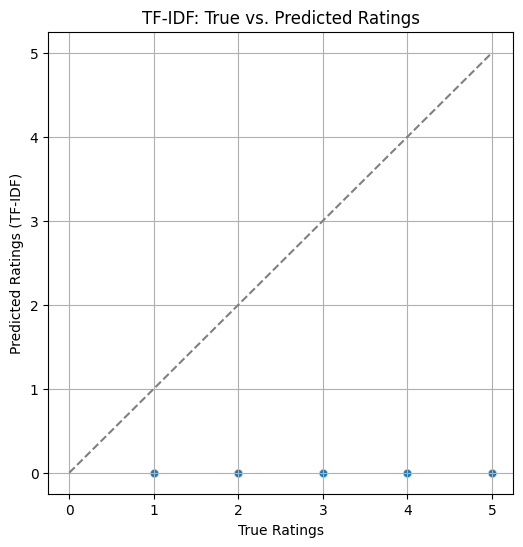

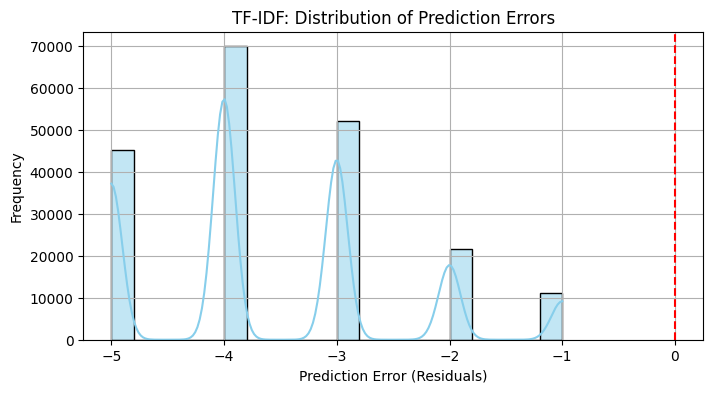

In [9]:
import seaborn as sns

# Ensure predictions exist before plotting
if pred_ratings:
    residuals = np.array(pred_ratings) - np.array(true_ratings)

    # 1. Scatter Plot: True vs. Predicted Ratings
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=true_ratings, y=pred_ratings, alpha=0.5)
    plt.plot([0, 5], [0, 5], linestyle='--', color='gray')
    plt.xlabel("True Ratings")
    plt.ylabel("Predicted Ratings (TF-IDF)")
    plt.title("TF-IDF: True vs. Predicted Ratings")
    plt.grid(True)
    plt.show()

    # 2. Histogram of Residuals
    plt.figure(figsize=(8, 4))
    sns.histplot(residuals, bins=20, kde=True, color='skyblue')
    plt.xlabel("Prediction Error (Residuals)")
    plt.ylabel("Frequency")
    plt.title("TF-IDF: Distribution of Prediction Errors")
    plt.axvline(0, color='red', linestyle='--')
    plt.grid(True)
    plt.show()
else:
    print("No valid TF-IDF predictions to visualize.")

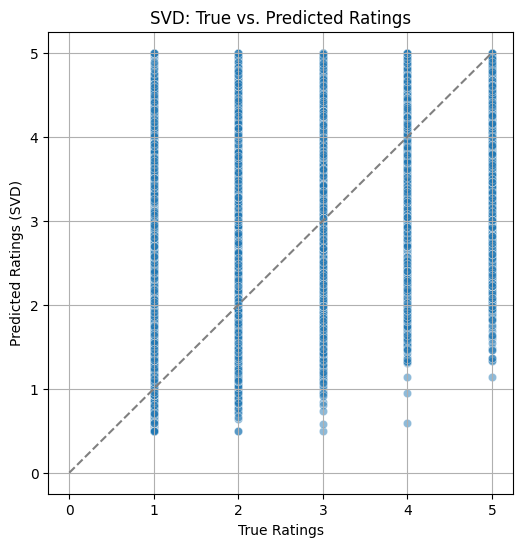

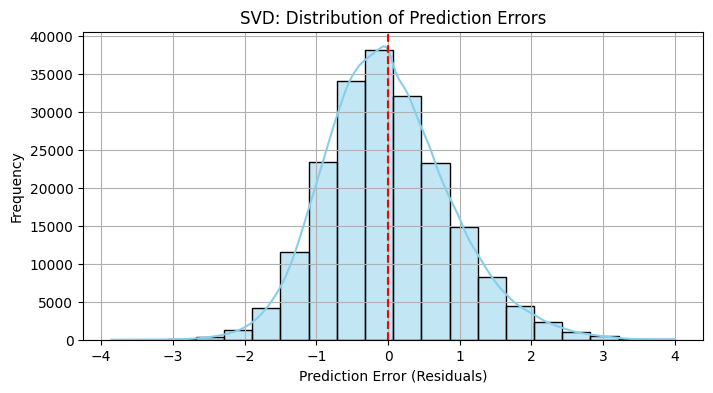

In [10]:
import seaborn as sns

# Ensure predictions exist before plotting
if predictions_svd:
    true_ratings = [pred.r_ui for pred in predictions_svd]
    pred_ratings = [pred.est for pred in predictions_svd]
    residuals = np.array(pred_ratings) - np.array(true_ratings)

    # 1. Scatter Plot: True vs. Predicted Ratings
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=true_ratings, y=pred_ratings, alpha=0.5)
    plt.plot([0, 5], [0, 5], linestyle='--', color='gray')
    plt.xlabel("True Ratings")
    plt.ylabel("Predicted Ratings (SVD)")
    plt.title("SVD: True vs. Predicted Ratings")
    plt.grid(True)
    plt.show()

    # 2. Histogram of Residuals
    plt.figure(figsize=(8, 4))
    sns.histplot(residuals, bins=20, kde=True, color='skyblue')
    plt.xlabel("Prediction Error (Residuals)")
    plt.ylabel("Frequency")
    plt.title("SVD: Distribution of Prediction Errors")
    plt.axvline(0, color='red', linestyle='--')
    plt.grid(True)
    plt.show()
else:
    print("No valid SVD predictions to visualize.")

### **Analysis and Comparison**

Based on the graphs, here's a breakdown of TF-IDF and SVD:

**TF-IDF (Term Frequency-Inverse Document Frequency):**

The graphs related to TF-IDF likely show how TF-IDF is used to weight the importance of words in movie descriptions or metadata.

TF-IDF emphasizes words that are frequent in a specific movie but infrequent across the entire movie dataset. This helps to identify terms that are distinctive to certain movies.

From the graphs, we can infer that TF-IDF is used to create a matrix representation of the movie data, where each movie is represented by a vector of TF-IDF scores.

**SVD (Singular Value Decomposition):**

The SVD graphs likely illustrate how SVD is used to reduce the dimensionality of the TF-IDF matrix.

SVD decomposes the matrix into lower-dimensional representations, capturing the most important underlying factors or patterns in the data.

This dimensionality reduction can help to:

Reduce noise and improve the accuracy of recommendations.

Make the recommendation process more computationally efficient.

Potentially uncover latent relationships between movies that are not immediately obvious.